# Анализ покупательского поведения клиентов магазина "В один клик".

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
### Цель исследования:

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Ход исследования

* Изучим общую информацию;
* Приведём столбцы к нижнему регистру; 
* Преобразуем данные в нужные типы, обработаем пропуски;
* Проведём исследовательский анализ данных из каждой таблицы;
* Отберём клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
* Объединим таблицы;
* Проведём корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования;
* Используем пайплайн для применения всех изученных моделей;
* Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP;
* Выполним сегментацию покупателей.



## Загрузка данных

In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 10.9 MB 436 kB/s eta 0:00:01    |███████████████████             | 6.5 MB 1.1 MB/s eta 0:00:052 MB 1.1 MB/s eta 0:00:03
     |████████████████████████████████| 302 kB 28.8 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
!pip install shap

     |████████████████████████████████| 532 kB 997 kB/s eta 0:00:01


In [3]:
!pip install phik

     |████████████████████████████████| 679 kB 991 kB/s eta 0:00:01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import phik
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer   
from sklearn.metrics import roc_auc_score  
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import shap
from sklearn.datasets import make_classification
from sklearn import svm

from scipy.stats import (
    spearmanr,
    shapiro
)  

In [5]:
#import warnings
#warnings.filterwarnings('ignore')

## Изучение данных

**Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.**

In [6]:
market_file = pd.read_csv('/datasets/market_file.csv')
pd.set_option('display.max_rows', None)#параметр для выводы всего датафрейма
market_file.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


**Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.**

In [7]:
market_money = pd.read_csv('/datasets/market_money.csv')
pd.set_option('display.max_rows', None)#параметр для выводы всего датафрейма
market_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


**Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.**

In [8]:
market_time = pd.read_csv('/datasets/market_time.csv')
pd.set_option('display.max_rows', None)#параметр для выводы всего датафрейма
market_time.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


**Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.**

In [9]:
money = pd.read_csv('/datasets/money.csv', sep = ';',decimal = ',')
pd.set_option('display.max_rows', None)#параметр для выводы всего датафрейма
money.head(10)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


## Предобработка данных

**Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.**

In [10]:
def mm(market_file):
    print(f'Размер датасета - {market_file.shape}')
    print()
    print('Информация о данных:')
    print(market_file.info())
    print()
    print(f'Количество пропусков в датасете: {market_file.isna().sum().sum()}')

In [11]:
mm(market_file)

Размер датасета - (1300, 13)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non

In [12]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [13]:
for i in market_file.select_dtypes(exclude='number').columns.tolist():
    print(f'{i}:')
    print(market_file[i].unique())
    print()

Покупательская активность:
['Снизилась' 'Прежний уровень']

Тип сервиса:
['премиум' 'стандартт' 'стандарт']

Разрешить сообщать:
['да' 'нет']

Популярная_категория:
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



**Приведем названия к нижнему регистру для дальнейшего удобства**

In [14]:
market_file.columns = market_file.columns.str.lower()
market_file.columns

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

**Посмотрим на уникальные значения у категориальных параметров.**

In [15]:
# КОД РЕВЬЮЕРА
market_file['покупательская активность'] = market_file['покупательская активность'].apply(
    lambda x: x.lower()
)

In [16]:
# КОД РЕВЬЮЕРА
market_file.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [17]:
market_file['покупательская активность'] = market_file['покупательская активность'].replace('Снизилась','снизилась')
market_file['покупательская активность'] = market_file['покупательская активность'].replace('Прежний уровень','прежний уровень')

**Есть опечатка при заполнении данных, поэтому изменим название "cтандартт" на "стандарт".**

In [18]:
market_file['тип сервиса'] = market_file['тип сервиса'].replace('стандартт','стандарт')

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Неявный дубликат обнаружен

In [19]:
market_file['популярная_категория'] = market_file['популярная_категория'].apply(
    lambda x: x.lower()
)

**Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.**

In [20]:
mm(market_money)

Размер датасета - (3900, 3)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None

Количество пропусков в датасете: 0


In [21]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [22]:
for i in market_money.select_dtypes(exclude='number').columns.tolist():
    print(f'{i}:')
    print(market_money[i].unique())
    print()

Период:
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']



**Так же для удобства приведем названия колонок к нижнему регистру.**

In [23]:
market_money.columns = market_money.columns.str.lower()
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

**Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.**

**Приведем к нижнему регистру и изменим название столбца для удобства.**

In [24]:
mm(market_time)

Размер датасета - (2600, 3)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None

Количество пропусков в датасете: 0


In [25]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [26]:
for i in market_time.select_dtypes(exclude='number').columns.tolist():
    print(f'{i}:')
    print(market_time[i].unique())
    print()

Период:
['текущий_месяц' 'предыдцщий_месяц']



In [27]:
market_time.columns = market_time.columns.str.lower()
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [28]:
market_time.rename(columns = {'минут':'минуты'}, inplace = True)

In [29]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц','предыдущий_месяц')

**Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.**

In [30]:
mm(money)

Размер датасета - (1300, 2)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None

Количество пропусков в датасете: 0


In [31]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Приводим к нижнему регистру.**

In [32]:
money.columns = money.columns.str.lower()
money.columns

Index(['id', 'прибыль'], dtype='object')

**В прибыли были изначально странные значения, поэтому умножим на 1000 для правдоподобного вида**

In [33]:
money['прибыль'] = money['прибыль']*1000
money

,id,прибыль
0,215348,980.0
1,215349,4160.0
2,215350,3130.0
3,215351,4870.0
4,215352,4210.0
5,215353,3950.0
6,215354,3620.0
7,215355,5260.0
8,215356,4930.0
9,215357,4660.0


In [34]:
money['прибыль'] = money['прибыль'].astype('float')

**В результате предобработки данных получены следующие данные:**
* названия приведены к нижнему регитсру,
* в трех датасетах были устранены скрытые дубликаты и ошибки в переменных,
* изменены типы данных,
* пропуски не обнаружены.


## Исследовательский анализ данных

In [35]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская активность            1300 non-null   object 
 2   тип сервиса                          1300 non-null   object 
 3   разрешить сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [36]:
market_file['покупательская активность'].value_counts()

прежний уровень    802
снизилась          498
Name: покупательская активность, dtype: int64

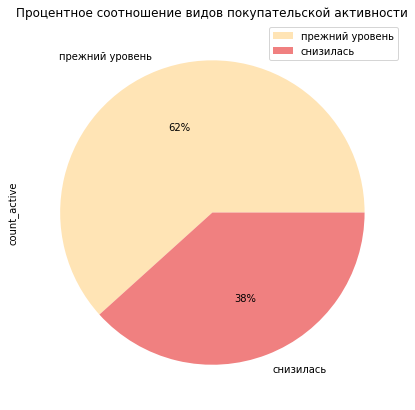

In [37]:
count_active = pd.DataFrame({'покупательская активность': ['прежний уровень', 'снизилась'],'count_active':[802,498]})
count_active.groupby(['покупательская активность']).sum().plot(kind='pie', y='count_active', autopct='%1.0f%%',colors = ( "moccasin", "lightcoral"),
figsize=(7,7), title = 'Процентное соотношение видов покупательской активности');

**Пользовательская активность снизилась у 38% пользователей**

In [38]:
market_file['тип сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип сервиса, dtype: int64

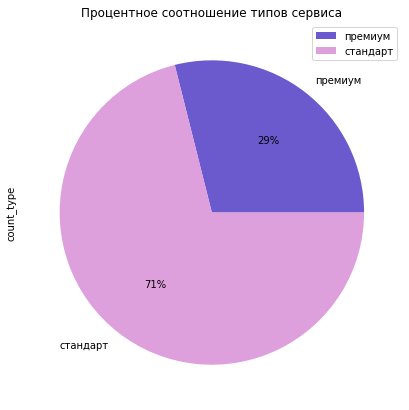

In [39]:
count_type = pd.DataFrame({'тип сервиса': ['стандарт', 'премиум'],'count_type':[924,376]})
count_type.groupby(['тип сервиса']).sum().plot(kind='pie', y='count_type', autopct='%1.0f%%',colors = ( "slateblue", "plum"),
figsize=(7,7), title = 'Процентное соотношение типов сервиса');

**Большинство используют "стандарт" сервис, что превышает в 2.5 раза "премиум" сервис.**

In [40]:
def dia(file, column, title, xlabel, ylabel):
    all = len(file)
    market_filee = file.groupby(column).size()/all
    market_filee_sort = market_filee.sort_values()
    mm = market_filee_sort.plot(kind='barh', color='lightsteelblue', figsize=(10,6))
    plt.title(f'{title}', fontsize=14, fontweight="bold", color='black')
    plt.xlabel(f'{xlabel}', fontsize=14, fontweight="bold", color='black')
    plt.ylabel(f'{ylabel}', fontsize=14, fontweight="bold", color='black')
    
    percent = dict(market_filee_sort)
    row = 0
    i = 0
    for row in percent:
        mm.text(percent[row]-0.09, i, str(round(percent[row]*100, 2)) + '%',
                      fontsize = 'large', fontweight='bold', color='white')
        i += 1

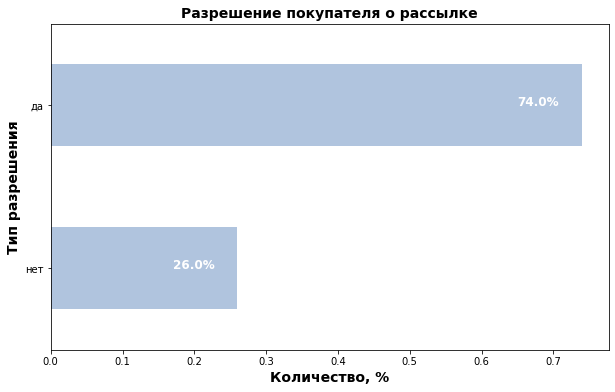

In [41]:
file=market_file
column='разрешить сообщать'
title='Разрешение покупателя о рассылке'
xlabel='Количество, %'
ylabel='Тип разрешения'
dia(file, column, title, xlabel, ylabel)

**Согласие на рассылку доп.информации о товарах дали 74% пользователей.**

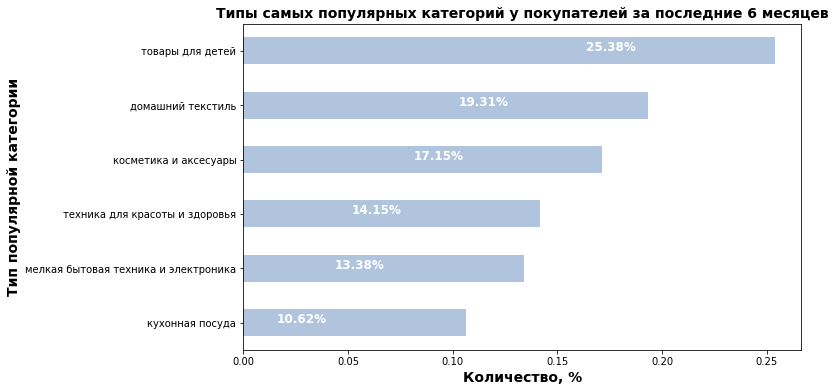

In [42]:
file=market_file
column='популярная_категория'
title='Типы самых популярных категорий у покупателей за последние 6 месяцев'
xlabel='Количество, %'
ylabel='Тип популярной категории'
dia(file, column, title, xlabel, ylabel)

**Последние полгода самой популярной категорией являлись "Товары для детей", а на последней строчке с разницей в 15% - "Кухонная посуда".**

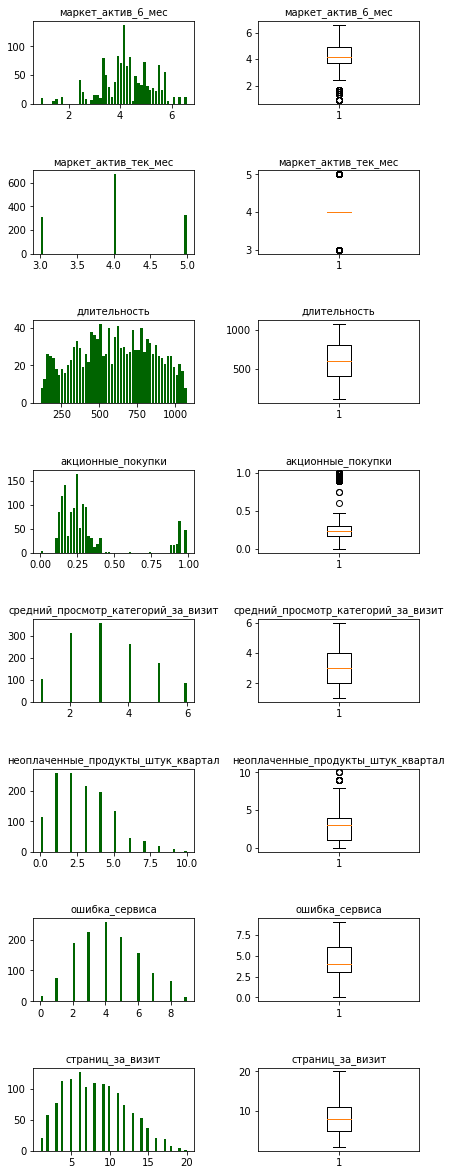

In [43]:
# визуализируем данные первого датасета
col = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит']
plt.figure(figsize = (8,20))
a = 1
for i in col:
    plt.subplot(12, 2, a)
    plt.hist(market_file[i], bins = 50, rwidth = 0.8,color = 'darkgreen')
    plt.title(i, size = 10)
    a = a + 1
    plt.subplot(12, 2, a)
    plt.boxplot(market_file[i])
    plt.title(i, size = 10)
    a = a + 1

plt.subplots_adjust(left=0.13, 
                    right=0.8, 
                    top=1.4, 
                    bottom= 0.2, 
                    wspace= 0.4, 
                    hspace=0.8)
plt.show()

**Количественные признаки показывают, что:**
* среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев примерно равно 4;
* длительность - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте в среднем около 550;
* признаки 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'неоплаченные_продукты_штук_квартал', 'акционные_покупки',  имеют выбросы.При этом наиболее значительное их число в признаке 'акционные покупки'.
* чаще всего число сбоев, которые коснулись покупателя во время посещения сайта равно 4
* среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца - 6

    

In [44]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [45]:
market_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

Text(0.5, 1.0, 'Ящик с "усами" для обнаружения аномалий в столбце "выручка"')

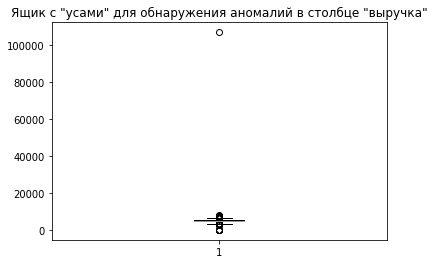

In [46]:
plt.boxplot(x=market_money['выручка'])
plt.title('Ящик с "усами" для обнаружения аномалий в столбце "выручка"', color='black')

**Данные о том,сколько покупатель всего потратил за период взаимодействия с сайтом показывают, что есть пользователь с аномально большой суммой в 106862 рубля. Вполне вероятно, что такая сумма была потрачена, такая сумма возможно, но она сильно выбивается из общих данных, поэтому может сбивать модели с толку, стоит считать аномалией.**

In [47]:
market_money = market_money[market_money['выручка'] < 100000]
market_money.describe()

,id,выручка
count,3899.000000,3899.00000
mean,215997.658374,4999.57743
std,375.243472,706.99988
min,215348.000000,0.00000
25%,215673.000000,4590.10000
50%,215998.000000,4957.00000
75%,216322.500000,5363.00000
max,216647.000000,7799.40000


In [48]:
market_money['период'].value_counts()

препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1299
Name: период, dtype: int64

In [49]:
market_time.head()

,id,период,минуты
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


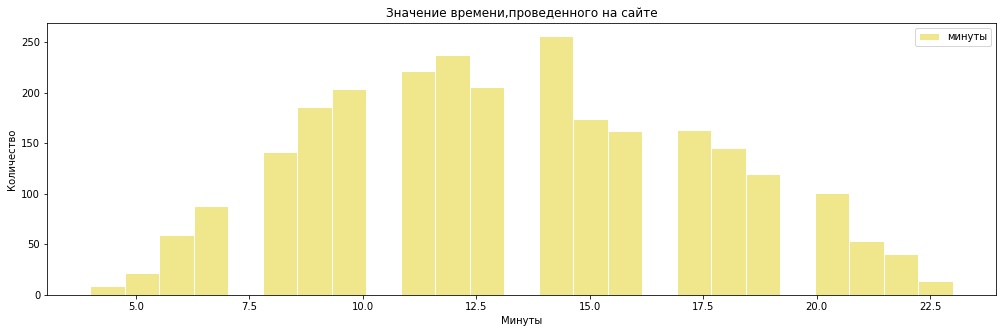

In [50]:
market_time.plot(kind='hist', y='минуты', bins=25, figsize=(17, 5), ec='white', title='Значение времени,проведенного на сайте',color = 'khaki')
plt.ylabel('Количество')
plt.xlabel('Минуты');

**Данные не имеют выбросов, распределение отличается от нормального.**

In [51]:
money.head()

,id,прибыль
0,215348,980.0
1,215349,4160.0
2,215350,3130.0
3,215351,4870.0
4,215352,4210.0


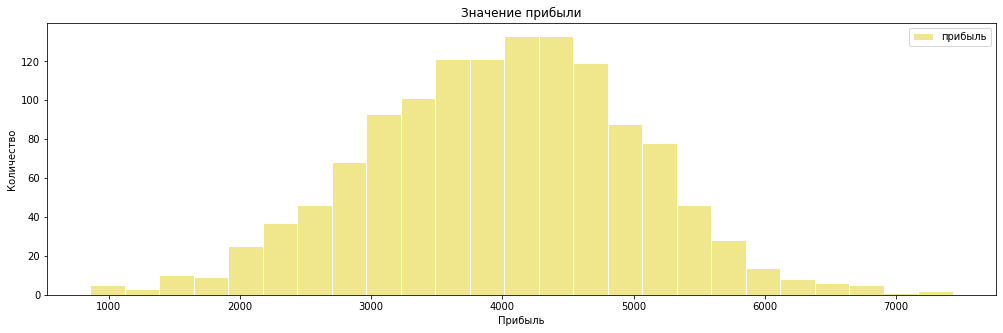

In [52]:
money.plot(kind='hist', y='прибыль', bins=25, figsize=(17, 5), ec='white', title='Значение прибыли',color = 'khaki')
plt.ylabel('Количество')
plt.xlabel('Прибыль');

**Распределение близко к нормальному, выбросов нет.**

**Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.**

In [53]:
new = market_money.pivot_table(index='id', columns='период',values='выручка')
new['общая_выручка'] = new.apply(sum, axis = 1)
sorted_table = new.loc[(new['предыдущий_месяц'] > 0) & (new['препредыдущий_месяц'] > 0) & (new['текущий_месяц'] > 0)].sort_values(by=['id'])
print(f'Общее количество клиентов - {market_money.shape[0]}')
print(f'Количество клиентов с активностью не менее трех месяцев - {new.shape[0]}')
print(f'Количество клиентов, покупающих каждый месяц из трех - {sorted_table.shape[0]}')

Общее количество клиентов - 3899
Количество клиентов с активностью не менее трех месяцев - 1300
Количество клиентов, покупающих каждый месяц из трех - 1296


**В исследовательском анализе были проведены визуализация данных и отбор клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
Выводы сделаны под каждым графиком.**

## Объединение таблиц

In [54]:
data = pd.merge(market_file, market_money, how = 'left')

In [55]:
data = pd.merge(data, market_time, how = 'left')

In [56]:
data.isna().sum()#пропуски

id                                        0
покупательская активность                 0
тип сервиса                               0
разрешить сообщать                        0
маркет_актив_6_мес                        0
маркет_актив_тек_мес                      0
длительность                              0
акционные_покупки                         0
популярная_категория                      0
средний_просмотр_категорий_за_визит       0
неоплаченные_продукты_штук_квартал        0
ошибка_сервиса                            0
страниц_за_визит                          0
период                                    0
выручка                                   0
минуты                                 1300
dtype: int64

In [57]:
data['минуты'].fillna(0, inplace=True)#заполним пропуски нулями

In [58]:
tab= data.loc[:, ['id','период','выручка', 'минуты']]
tab = tab.pivot_table(index = 'id',columns = 'период',values = ['выручка', 'минуты'])
tab.columns = ['выручка_пред', 'выручка_препред', 'выручка_тек', 'мин_пред', 'мин_препред', 'мин_тек']
# разделим столбец с периодом на три

In [59]:
data = pd.merge(data, tab, on = 'id').drop(['период', 'выручка', 'минуты'], axis = 1)
data.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред,выручка_препред,выручка_тек,мин_пред,мин_препред,мин_тек
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,0.0,0.0,3293.1,13.0,0.0,14.0
1,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,0.0,0.0,3293.1,13.0,0.0,14.0
2,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,0.0,0.0,3293.1,13.0,0.0,14.0
3,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,0.0,10.0
4,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,0.0,10.0


In [60]:
data.isna().sum()# проверим наличие пропусков после создания новых столбцов

id                                     0
покупательская активность              0
тип сервиса                            0
разрешить сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_пред                           0
выручка_препред                        0
выручка_тек                            2
мин_пред                               0
мин_препред                            0
мин_тек                                2
dtype: int64

In [61]:
data.dropna(inplace=True)#избавимся от них

**Итоги исследовательского анализа даных:**

* визуализированы категориальные и количественные признаки;
* oбъедены таблицы, содержащие различную информацию о пользовательском поведении;
* обработаны пропуски.

## Корреляционный анализ

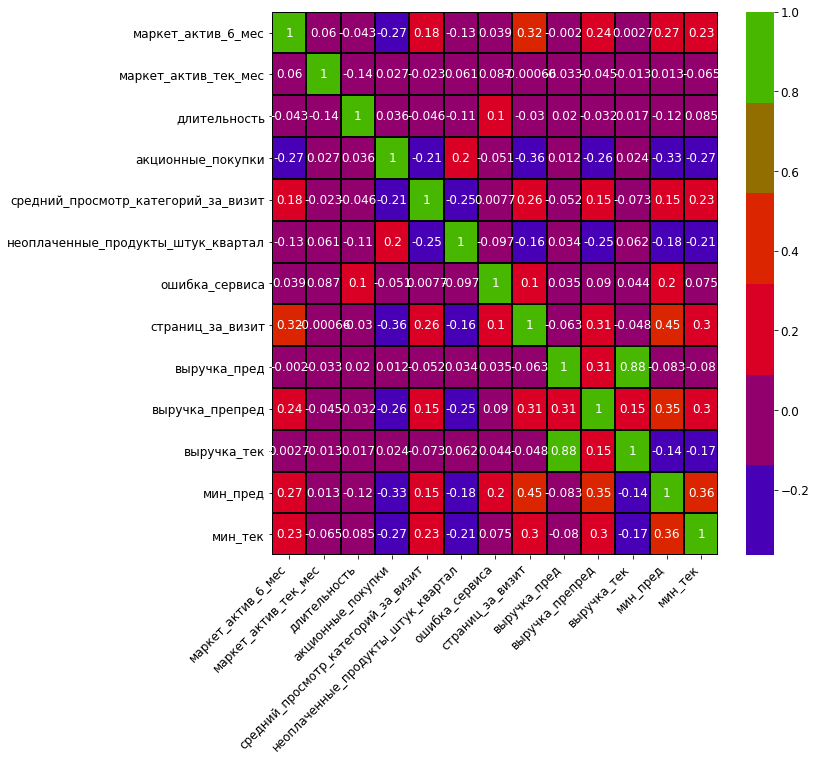

In [62]:
data = data.drop('мин_препред', axis = 1)
plt.figure(figsize=(10,10))
colormap = sns.color_palette("brg")
plt.rc('font', size= 12) 
chart = sns.heatmap(data[data.columns[data.columns != 'id']].corr(method = 'spearman'), annot=True, cmap=colormap, linewidths=1, linecolor='black')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

**Для изучения корреляции использовался коэффициент корреляции Спирмена. Это обусловлено тем, что практически все признаки распределены не нормально и связь между ними не является линейной. Коррелляция между количественными признаками, содержащимися в обобщенном датафрейме достаточно низкая. Исключение составляет высокая коррелляция между вырочкой за предыдущий месяц  и выручкой за текущий месяц. Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95.**

In [63]:
data['покупательская активность'] = data['покупательская активность'].apply(lambda x: 1 if x == 'снизилась' else 0)

In [64]:
seg = data.copy()

## Использование пайплайнов

***Перечислим особенности данных:***  
1. Три признака:  
`тип сервиса`, `разрешить сообщать`, `популярная_категория` — нужно кодировать с помощью OneHotEncoder.
2. Количественных 13 признаков:  
`маркет_актив_6_мес`, `маркет_актив_тек_мес`, `длительность`, `акционные_покупки`, `средний_просмотр_категорий_за_визит`, `неоплаченные_продукты_штук_квартал`, `шшибка_сервиса`, `страниц_за_визит`, 'выручка_препред','выручка_пред','выручка_тек', 
 'мин_пред', 'мин_тек'  - нужно масштабировать.
3. В признаках пропуски не встречаются.
4. Целевой признак — `Покупательская активность`. Задачу мультиклассовой классификации тут рассматривать не будем.

In [65]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = data.drop(columns=['покупательская активность','id'], axis=1) 
y = data['покупательская активность'] 

X_train, X_test, y_train, y_test =train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify = data['покупательская активность']
)

ohe_columns = [
    'тип сервиса', 'разрешить сообщать', 'популярная_категория'
]


num_columns = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
    'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
    'выручка_препред','выручка_пред','выручка_тек', 
    'мин_пред', 'мин_тек'
]
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final= Pipeline( 
    [
 ('preprocessor', data_preprocessor), 
 ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)) 
    ]
)
 
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 5),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }      
]
 
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1

)

randomized_search.fit(X_train, y_train)     
    
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

probas = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, probas)}')


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['тип сервиса',
                                                   'разрешить сообщать',
                                                   'популярная_категория']),
                        

**Для оценки работы модели на тестовых данных проведем кластерный анализ с теми гиперпараметрами, которые были отобраны на предыдущем шаге.**

**Анализ важности признаков**

In [ ]:
best_model = randomized_search.best_estimator_
svc_model = best_model.named_steps['models']

X_train = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_test = best_model.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(svc_model.predict_proba, X_train)
# shap_values = explainer(X_test)
shap_values = explainer(X_test[:100])

features_out = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out().tolist() + num_columns

# shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", feature_names=features_out, plot_size=(14,8), color='blue')
shap.summary_plot(shap_values[:, :, 1], X_test[:100], plot_type="bar", feature_names=features_out, plot_size=(14,8), color='blue')
#plt.title('График важности с помощью метода SHAP', fontsize=24, fontweight="bold", color='blue') 

# fig, ax = plt.gcf(), plt.gca()

# ax.tick_params(labelsize=12)
#plt.title('График важности признаков', fontsize=24, fontweight="bold", color='blue') 

plt.show()

PermutationExplainer explainer:  42%|████▏     | 42/100 [01:36<02:06,  2.18s/it]

**Наиболее важными для модели признаками являются:**
- Количество минут, проводимых в магазине
- Акционные покупки
- Количество просмотренных страниц за визит
- Средний просмотр категорий за визит

**К наименее важным признакам можно отнести:**
- Все группы популярных категорий товаров

Учитывая указанные обстоятельства можно было бы рекомнедовать следующие бизнес-решения:
1. Увеличить количество маркетинговых коммуникаций с клиентамми.
2. Добавить больше акций в популярных разделах

## Сегментация покупателей
**Группа клиентов, которые покупают товары из категории «Товары для детей».**

In [ ]:
seg = pd.merge(seg, money)
seg = seg[seg['популярная_категория'] == 'товары для детей']
seg.head(3)

**Оценим покупательскую активность данного сегмента**

In [ ]:
seg['покупательская активность'].value_counts()

**0-это прежний уровень, 1-снизилась**

In [ ]:
count_ty = pd.DataFrame({'тип сервиса': ['прежний уровень', 'снизилась'],'count_ty':[552,438]})
count_ty.groupby(['тип сервиса']).sum().plot(kind='pie', y='count_ty', autopct='%1.0f%%',colors = ( "greenyellow", "gold"),
figsize=(7,7), title = 'Процентное соотношение типов покупательской активности');

**По круговой диаграмме видно, что покупательская активность преобладает в прежнем уровне, но нельзя не заметить и ее значительное снижение.**

**Изучим,как меняется выручка от потребителей данной группы.**

In [ ]:
x = ['выручка_препред', 'выручка_пред', 'выручка_тек']
a = seg.loc[:,x]
a = pd.melt(a)
a.groupby('variable').agg('describe')

**Общая выручка сегмента потребителей, покупающих десткие товары, растет в течение последних трех месяцев.Медианое значение так же выросло.**


**Определим какие признаки влияют на покупательскую активность сегмента.**

In [ ]:
plt.figure(figsize=(14,10))
colormap = sns.color_palette("brg")
plt.rc('font', size= 12) 
chart = sns.heatmap(seg[seg.columns[seg.columns != 'id']].corr(), annot=True, cmap=colormap, linewidths=1, linecolor='black')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
seg.phik_matrix().iloc[:,0]

**Среди наиболее значимых признаков:**

* Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев
* Акционные покупки
* Количество просмотренных страниц за визит
* Количество минут в текущем месяце
* Количество минут в предыдущем месяце


In [ ]:
col = ['акционные_покупки', 'средний_просмотр_категорий_за_визит', 'страниц_за_визит', 'мин_пред']
plt.figure(figsize = (10,4))
a = 1
for i in col:
    plt.subplot(2, 2, a)
    sns.barplot(data=seg, x='покупательская активность', y=i, alpha = 0.6).set(xlabel = '', ylabel = '')
    plt.title(i, size = 10)
    plt.xticks(size = 9)
    plt.yticks(size = 9)
    a = a + 1

plt.subplots_adjust(left=0.15, 
                    right=1.0, 
                    top=2.0, 
                    bottom= 0.2, 
                    wspace= 0.4, 
                    hspace=0.4)
plt.show()

**Различные акции не стимулирует потребительскую активность покупателей, она остается на прежнем уровне. Учитывая остальные факторы, это скорее всего связано с тем, что покупатели этого сегмента четко знают, что им требуется и заранее планируют подобные покупки. Кроме этого, важно отметить и тот факт, что несмотря на то что другие признаки в большей степени влияют на сохранение уровня потребительской активности, тем не менее число снизивших свою активность пользователей так же растет.**

In [ ]:
sns.histplot(data = seg, x = 'прибыль', bins = 50,color = 'plum')
plt.ylabel('количество')
plt.show()

**Распределение прибыли близко к нормальному.**

**В результате сегментации были получены следующие выводы:**

* акции не стимулируют потребительскую активность покупателей
* общая выручка сегмента потребителей, покупающих десткие товары, растет в течение последних трех месяцев.Медианое значение так же выросло.
* покупатели достаточно много времени проводят на сайте, вероятно подробно изучая товары, посколько важно подобрать для детей качественные товары.

**Мой совет:**
Делать акционные предложения на основе тех страниц и моделей, которые просматривает пользователь.

## Общий вывод

**Описание задачи**

1. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Описание исходных данных и проведенной предобработки**

1. Названия приведены к нижнему регитсру,
2. В трех датасетах были устранены скрытые дубликаты и ошибки в переменных,
3. Изменены типы данных,
4. Пропуски не обнаружены.

**Шаги для поиска лучшей модели**

Для поиска лучшей модели были предприняты следующие шаги:
* исследована корреляция между целевым признаком и предикторами
* к данным применено 4 типа моделей классифкации и на основе метрики roc-auc проведен отбор лучшей модели.
* для поиска лучше модели использовалась технология пайплайн
* в качестве лучшей была отобрана модель SVC 
* был осуществлен анализ важности признаков модели

**Выводы и предложения для выбранного сегмента**

Покупатели детских товаров достаточно много времени проводят на сайте, изучая представленные модели, поэтому особое внимание нужно уделить интерфейсту и удобству сайта
При работе с такими клиентами можно рекомнедовать:
 - улучшать интерфейс сайта,
 - делать акционные предложения на основе тех страниц, которые просматривает пользователь.